# Script for Generating Training Data from Frames using PIPs
https://github.com/aharley/pips

## Initial set up
Connection to MyDrive, requirements, imports, downloading models weights

In [50]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# installing requirements
!pip install imageio==2.19.3
!pip install opencv-python==4.6.0.66
!pip install einops==0.4.1
!pip install scikit-learn==1.1.1
!pip install matplotlib==3.5.1
!pip install protobuf==3.20.0
!pip install fire==0.4.0

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/drive_folder/pips')
import time
import numpy as np
import io
import os
from PIL import Image
import cv2
import saverloader
from nets.pips import Pips
import utils.improc
import random
import glob
from utils.basic import print_, print_stats
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import imageio.v2 as imageio
from csv import writer
# imports pytorch
import torch

In [ ]:
# downloading their reference model
!bash /content/drive/MyDrive/drive_folder/pips/get_reference_model.sh

## Loading zip folder with data frames
used to compute particle flow

In [2]:
DATA_DIR = "synthetic_data_2023-03-07" # specify the name of the data folder located in drive
# !unzip -d "$DATA_DIR"/ /content/drive/MyDrive/"$DATA_DIR".zip # unziping frames

In [4]:
# List of videos to go through
videos_list = sorted([f for f in os.listdir(DATA_DIR+'/') if not f.startswith('.')])
print(videos_list)

['video0000', 'video0001', 'video0002', 'video0003', 'video0004', 'video0005', 'video0006', 'video0007', 'video0008', 'video0009', 'video0010', 'video0011', 'video0012', 'video0013', 'video0014', 'video0015', 'video0016', 'video0017', 'video0018', 'video0019', 'video0020', 'video0021', 'video0022', 'video0023', 'video0024', 'video0025', 'video0026', 'video0027', 'video0028', 'video0029', 'video0030', 'video0031', 'video0032', 'video0033', 'video0034', 'video0035', 'video0036', 'video0037', 'video0038', 'video0039', 'video0040', 'video0041', 'video0042', 'video0043', 'video0044', 'video0045', 'video0046', 'video0047', 'video0048', 'video0049', 'video0050', 'video0051', 'video0052', 'video0053', 'video0054', 'video0055', 'video0056', 'video0057', 'video0058', 'video0059', 'video0060', 'video0061', 'video0062', 'video0063', 'video0064', 'video0065', 'video0066', 'video0067', 'video0068', 'video0069', 'video0070', 'video0071', 'video0072', 'video0073', 'video0074', 'video0075', 'video0076'

## Generating training data

## Helper functions

In [5]:
def img_to_array(tensor_img):
  """
  Change tensor to numpy array for storing of images
  - resizing to 640x360 (to match coords resolution)
  - normalising pixel value to range 0-1 (required for input to FCN ResNet-50)
  """
  x = tensor_img.permute(1, 2, 0).numpy()
  x = cv2.resize(x, (640, 360))
  x = x.astype(float) / 255
  return x

def save_data(sample_id, frame0, frame3, frame7, trajs, vis):
  """
  Saving
  - coordinates to COORDS_DIR as .npy files
  - visibility of coordinates to VIS_DIR as .npy files
  - 0th frames to FRAME0_DIR directory as .npy files
  - 7th frames to FRAME7_DIR directory as .npy files
  
  - Coordinates, visibility and frames are mapped with sample_id, all sample_ids are stored in sample_ids.txt
  """
  img0 = img_to_array(frame0) # transform 0th frame to array
  img3 = img_to_array(frame3) # transform 2nd frame to array
  img7 = img_to_array(frame7) # tranform last frame (8th) to array
  coords = trajs.cpu().numpy()
  vis = vis.cpu().numpy()

  # Store coords, frame0, frame1
  np.save(COORDS_DIR+sample_id, coords)
  np.save(VIS_DIR+sample_id, vis)
  np.save(FRAME0_DIR+sample_id, img0)
  np.save(FRAME3_DIR+sample_id, img3)
  np.save(FRAME7_DIR+sample_id, img7)

  # Add sample_id to log list
  LOG_LIST.append(sample_id)
  save_log(LOG_LIST)

def save_log(log_list):
  with open(LOG_FILE, "w") as outfile:
    outfile.write("\n".join(log_list))

## PIPs implementation

In [6]:
def create_model(model_weights):
  model = Pips(stride=4).cuda()
  parameters = list(model.parameters())
  _ = saverloader.load(model_weights, model)
  global_step = 0
  model.eval()
  return model

def run_model(model, rgbs, N, split):
    rgbs = rgbs.cuda().float() # B, S, C, H, W

    B, S, C, H, W = rgbs.shape
    rgbs_ = rgbs.reshape(B*S, C, H, W)
    H_, W_ = 360, 640
    rgbs_ = F.interpolate(rgbs_, (H_, W_), mode='bilinear')
    H, W = H_, W_
    rgbs = rgbs_.reshape(B, S, C, H, W)

    # Pick N points to track; we'll use a uniform grid
    N_ = np.sqrt(N).round().astype(np.int32)
    grid_y, grid_x = utils.basic.meshgrid2d(B, N_, N_, stack=False, norm=False, device='cuda')
    grid_y = 8 + grid_y.reshape(B, -1)/float(N_-1) * (H-16)
    grid_x = 8 + grid_x.reshape(B, -1)/float(N_-1) * (W-16)
    xy = torch.stack([grid_x, grid_y], dim=-1) # B, N_*N_, 2
    _, S, C, H, W = rgbs.shape

    print_stats('rgbs', rgbs)

    # Splitting grid of points into tensors of size 1500 along dim=1
    if split:
       xy_split = torch.split(xy, 1500, dim=1)
       preds_split = []
       vis_split = []

      # For each splitted point compute trajs
       for i in range(len(xy_split)):
         preds, preds_anim, vis, stats = model(xy_split[i], rgbs, iters=6)
         preds_split.append(preds[-1])
         vis_split.append(vis[-1])

       # Put trajs back together
       trajs_e = torch.cat(preds_split, 2)
       vis_e = torch.cat(vis_split, 1).unsqueeze(0)
       

    else:
      preds, preds_anim, vis, stats = model(xy, rgbs, iters=6)
      # preds is a list of torch tensors 
      trajs_e = preds[-1] # tensor of shape (frames, tracking points, 2)
      vis_e = vis

    print_stats('vis_e', vis_e)
    return trajs_e[:,-1,:,:], vis_e[:,-1,:]

def generate_training_data(pips_model, video_name, n, split=True):
    model = pips_model
    
    # Choose hyps
    B = 1
    S = 8
    N = n**2 # number of points to track

    # Get frames of a file
    filenames = glob.glob(DATA_DIR+'/'+video_name+'/*.jpg')
    filenames = sorted(filenames)


    max_iters = (len(filenames)//S) # run each unique subsequence
    global_step = 0

    # Run model each of 8 frames, from frame 100 to frame end-100 (to avoid titles in the video)
    while global_step < max_iters:
        global_step += 1
        
        try:
            rgbs = []
            sample_id = video_name[-4:]+"_"+str(global_step-1)
            print("sample {}: step {}/{}".format(sample_id, global_step, max_iters))

            # Skip generating this sample if it is already in the log list
            if sample_id in LOG_LIST:
                  print(sample_id+" already in log list")
                  continue

            for s in range(S):
                frame_num = (global_step-1)*S+s
                fn = filenames[frame_num]
                if s==0:
                    print('start frame', fn)
                im = imageio.imread(fn)
                im = im.astype(np.uint8)
                im = torch.from_numpy(im).permute(2,0,1)
                rgbs.append(im)
            rgbs = torch.stack(rgbs, dim=0).unsqueeze(0) # 1, S, C, H, W

            with torch.no_grad():
                trajs_e, vis_e = run_model(model, rgbs, N, split)

            # Store img0, img3 and img7 (first, middle and last frame) and trajs_e, vis_e
            save_data(sample_id, rgbs[0][0], rgbs[0][3], rgbs[0][-1], trajs_e, vis_e)

        except FileNotFoundError as e:
            print('error', e)

In [7]:
model = create_model('reference_model')

reading ckpt from reference_model
...found checkpoint reference_model/model-000100000.pth


## Creating/Loading folder to store data in

In [8]:
# Run this cell if you want to create a new dataset,
# will create a folder to store training data in
!rm -r training_data
!mkdir training_data
!mkdir training_data/frame0/
!mkdir training_data/frame3/
!mkdir training_data/frame7/
!mkdir training_data/coords/
!mkdir training_data/vis/
!touch training_data/sample_ids.txt
PATH = "/content/training_data"

In [ ]:
# Run this cell if we want to use an old training data folder
# specify the name of the data folder located in drive
TRAIN_DATA_DIR = "full_dataset_2023-02-18"
!unzip -d "$TRAIN_DATA_DIR"/ /content/drive/MyDrive/"$TRAIN_DATA_DIR".zip

# Set path to that folder
PATH = "/content/"+TRAIN_DATA_DIR

In [9]:
TRANING_DATA_DIR = PATH+"/"
COORDS_DIR = PATH+"/coords/"
VIS_DIR = PATH+"/vis/"
FRAME0_DIR= PATH+"/frame0/"
FRAME3_DIR= PATH+"/frame3/"
FRAME7_DIR= PATH+"/frame7/"
LOG_FILE = PATH+"/sample_ids.txt"
LOG_LIST = open(LOG_FILE).read().splitlines()

## Generating data

In [10]:
one_seventh = len(videos_list)//7
print(one_seventh)

361


In [11]:
videos_part1 = videos_list[:100]

for v in videos_part1:
  print("Now generating training data for {}.".format(v))
  generate_training_data(model, v, n=64)

Now generating training data for video0000.
sample 0000_0: step 1/2
start frame synthetic_data_2023-03-07/video0000/frame_000.jpg
rgbs (float32) min = 0.00, mean = 125.93, max = 255.00 torch.Size([1, 8, 3, 360, 640])
vis_e (float32) min = -12.13, mean = 5.42, max = 11.48 torch.Size([1, 8, 4096])
sample 0000_1: step 2/2
start frame synthetic_data_2023-03-07/video0000/frame_008.jpg
rgbs (float32) min = 0.00, mean = 127.88, max = 255.00 torch.Size([1, 8, 3, 360, 640])
vis_e (float32) min = -11.86, mean = 6.65, max = 11.81 torch.Size([1, 8, 4096])
Now generating training data for video0001.
sample 0001_0: step 1/3
start frame synthetic_data_2023-03-07/video0001/frame_000.jpg
rgbs (float32) min = 0.00, mean = 83.92, max = 255.00 torch.Size([1, 8, 3, 360, 640])
vis_e (float32) min = -12.30, mean = 5.69, max = 12.52 torch.Size([1, 8, 4096])
sample 0001_1: step 2/3
start frame synthetic_data_2023-03-07/video0001/frame_008.jpg
rgbs (float32) min = 0.00, mean = 83.39, max = 255.00 torch.Size([1,

In [ ]:
videos_part2 = videos_list[one_seventh:2*one_seventh]

for v in videos_part2:
  print("Now generating training data for {}.".format(v))
  generate_training_data(model, v, n=64)

## Zip data and store in Drive

### Check data was generated correctly

In [ ]:
from datetime import date
TODAY = date.today()
FILENAME = "synthetic_dataset_100"

# zip training data
!cd "$PATH" && zip -r /content/"$FILENAME"_"$TODAY".zip .
# cp NumPy zip file into drive
!cp "$FILENAME"_"$TODAY".zip /content/drive/MyDrive/

1043_0.npy (1, 16384, 2)


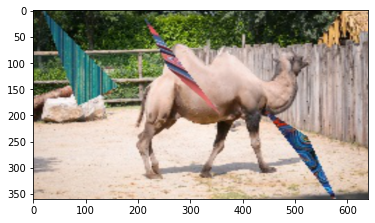

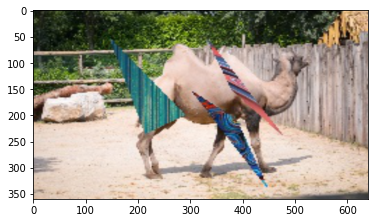

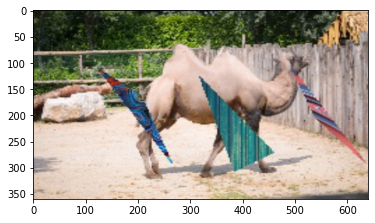

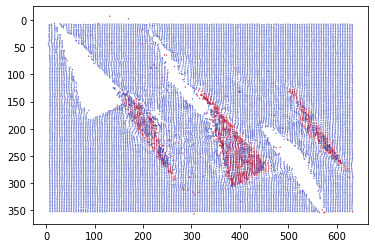

1043_1.npy (1, 16384, 2)


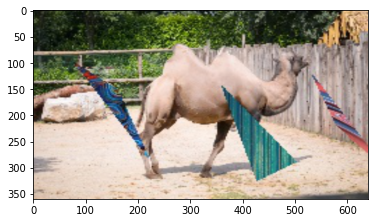

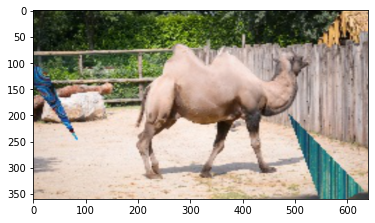

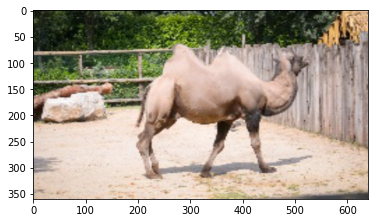

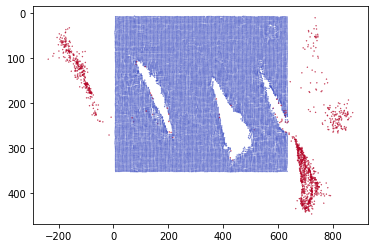

0900_5.npy (1, 16384, 2)


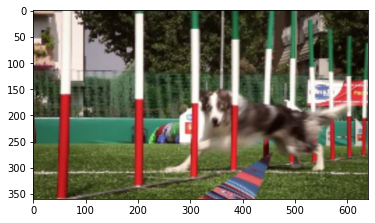

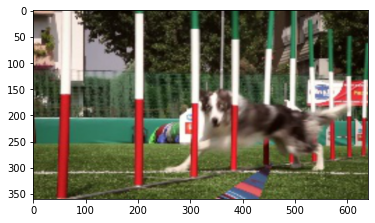

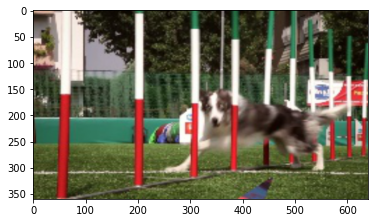

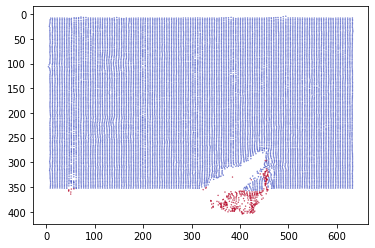

1583_0.npy (1, 16384, 2)


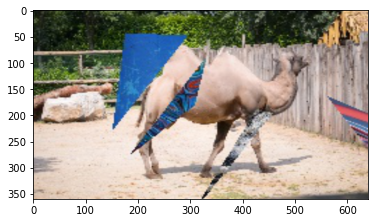

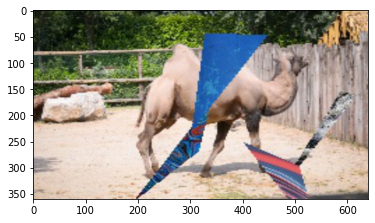

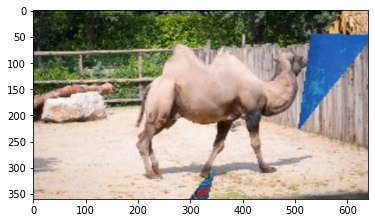

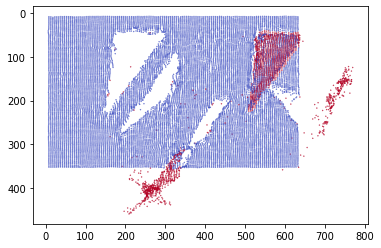

0900_0.npy (1, 16384, 2)


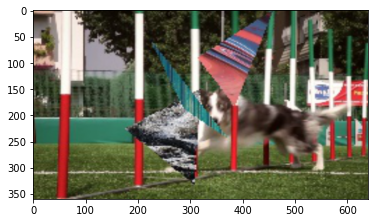

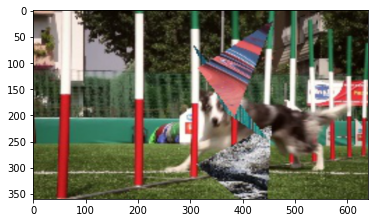

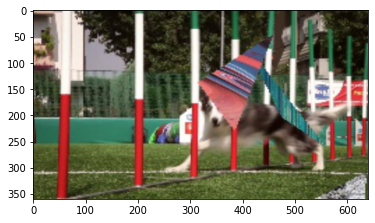

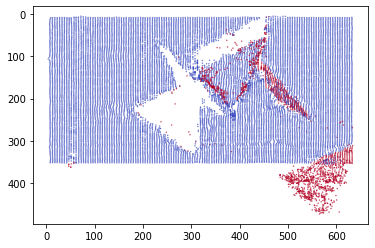

1583_1.npy (1, 16384, 2)


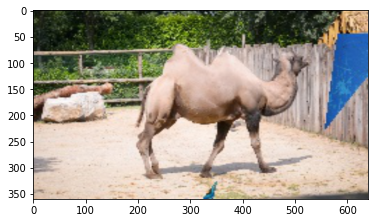

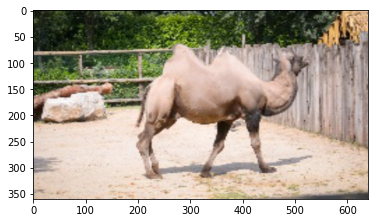

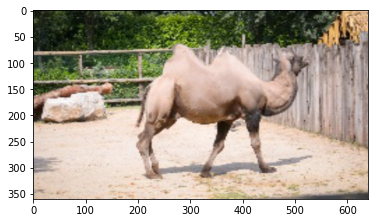

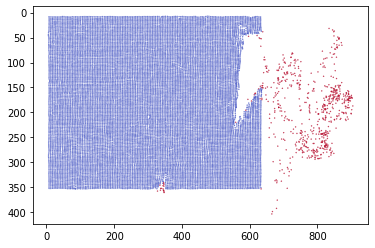

0900_4.npy (1, 16384, 2)


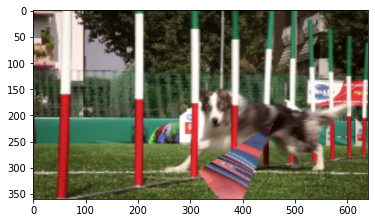

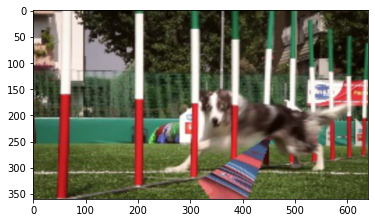

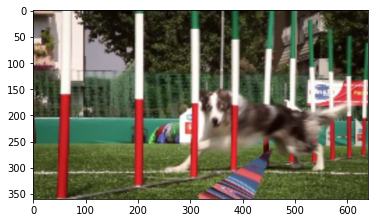

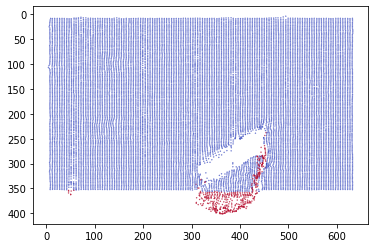

0901_0.npy (1, 16384, 2)


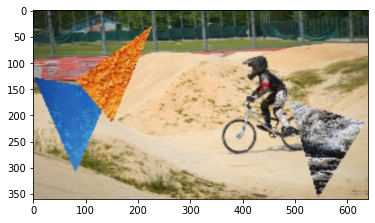

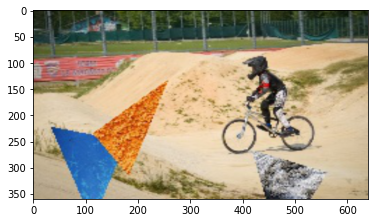

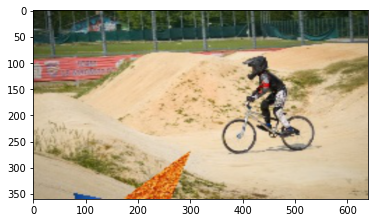

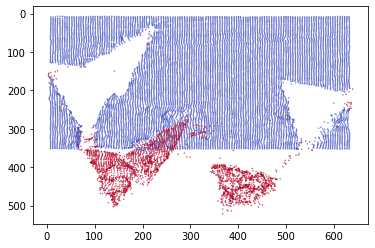

0900_2.npy (1, 16384, 2)


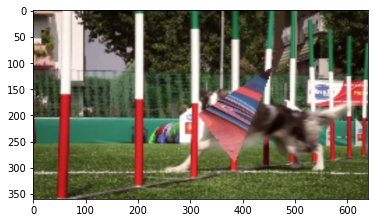

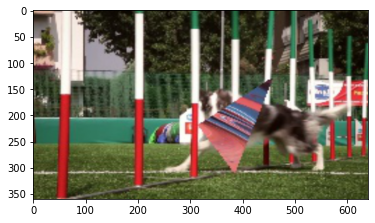

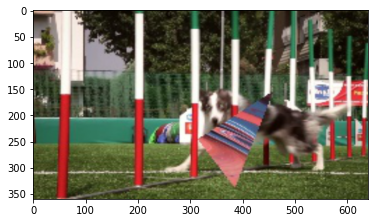

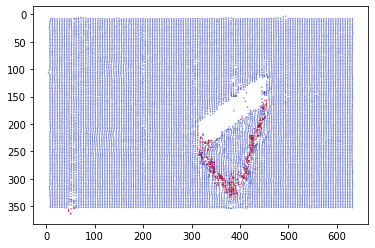

0901_1.npy (1, 16384, 2)


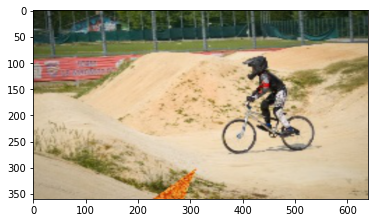

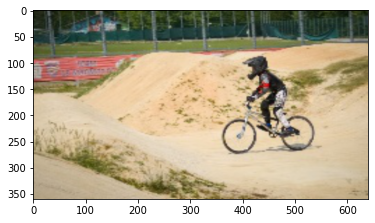

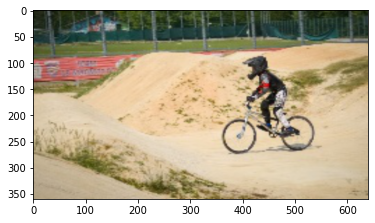

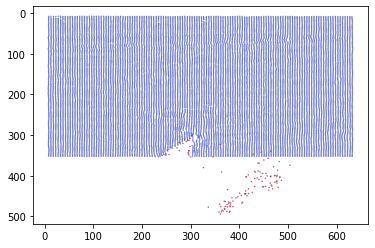

0900_1.npy (1, 16384, 2)


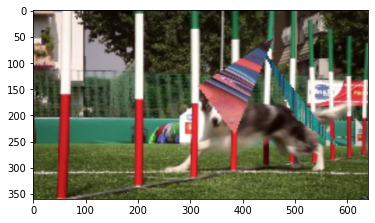

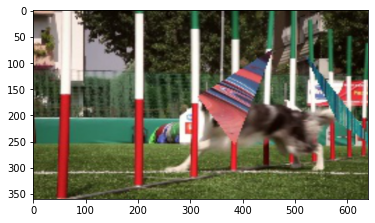

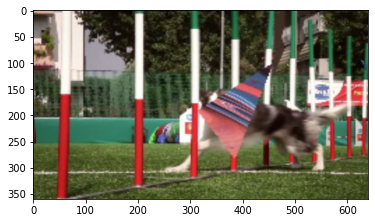

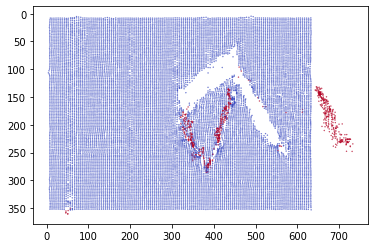

0900_6.npy (1, 16384, 2)


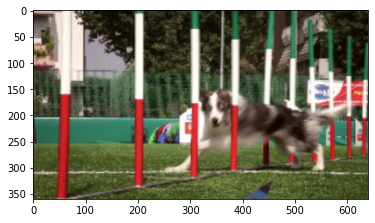

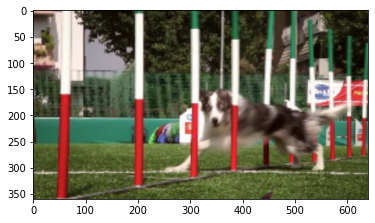

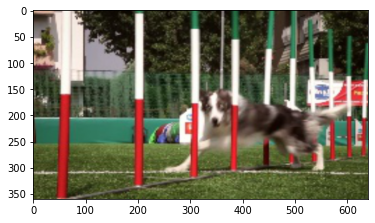

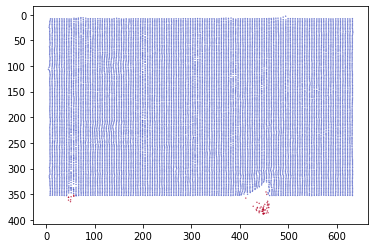

0900_3.npy (1, 16384, 2)


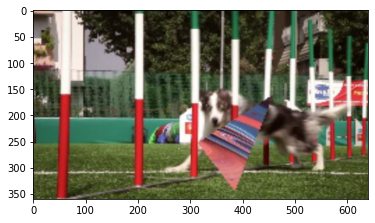

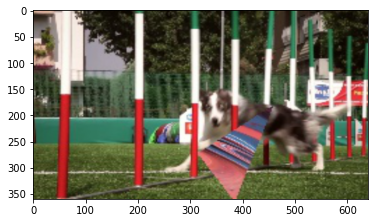

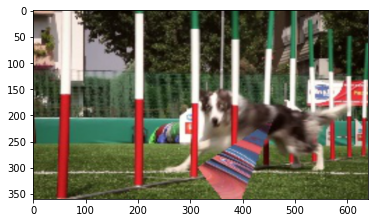

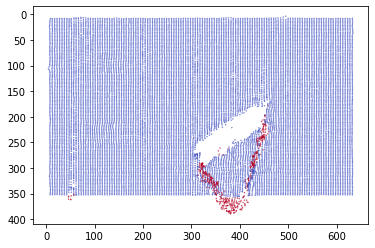

In [46]:
import os
import fnmatch

x = [f for f in os.listdir(PATH+'/coords/') if not f.startswith('.')] 
for name in x:
     print(name, np.load(PATH+'/coords/'+name, encoding='bytes').shape)
     img0 = np.load(PATH+'/frame0/'+name, encoding='bytes')
     plt.imshow(img0)
     plt.show()
     img3 = np.load(PATH+'/frame3/'+name, encoding='bytes')
     plt.imshow(img3)
     plt.show()
     img7 = np.load(PATH+'/frame7/'+name, encoding='bytes')
     plt.imshow(img7)
     plt.show()
     coords = np.load(PATH+'/coords/'+name, encoding='bytes')
     coords = coords.squeeze()
     vis = np.load(PATH+'/vis/'+name, encoding='bytes')
     vis = vis <= 0
     plt.scatter(coords[:, 0], coords[:, 1], s=0.5, c=vis, marker='.', cmap=plt.cm.coolwarm)
     plt.ylim(max(plt.ylim()), min(plt.ylim()))
     plt.pause(0.001)  # pause a bit so that plots are updated

## Split dataset

In [ ]:
!rm -r train_data
!mkdir train_data
!mkdir train_data/frame0/
!mkdir train_data/frame3/
!mkdir train_data/frame7/
!mkdir train_data/coords/
!mkdir train_data/vis/
!touch train_data/sample_ids.txt
PATH_TRAIN = "/content/train_data"

!rm -r validation_data
!mkdir validation_data
!mkdir validation_data/frame0/
!mkdir validation_data/frame3/
!mkdir validation_data/frame7/
!mkdir validation_data/coords/
!mkdir validation_data/vis/
!touch validation_data/sample_ids.txt
PATH_VALID = "/content/validation_data"

!rm -r test_data
!mkdir test_data
!mkdir test_data/frame0/
!mkdir test_data/frame3/
!mkdir test_data/frame7/
!mkdir test_data/coords/
!mkdir test_data/vis/
!touch test_data/sample_ids.txt
PATH_TEST = "/content/test_data"

LOG_FILE = PATH+"/sample_ids.txt"
LOG_LIST = open(LOG_FILE).read().splitlines()

In [ ]:
def save_log_to_file(log_list, file):
  with open(file, "w") as outfile:
    outfile.write("\n".join(log_list))

In [ ]:
# 80/10/10 train/valid/test split
np.random.seed(42)
np.random.shuffle(LOG_LIST)

train_list = LOG_LIST[:int(len(LOG_LIST)*0.8)]
valid_list = LOG_LIST[len(train_list):len(train_list)+int(len(LOG_LIST)*0.1)]
test_list = LOG_LIST[len(train_list)+len(valid_list):]

print(len(train_list))

3656


In [ ]:
import shutil
def save_split_dataset(path_from, path_to, sample_id_list):
  log_file = path_to+"/sample_ids.txt"
  log_list = open(log_file).read().splitlines()

  for sample_id in sample_id_list:
    shutil.move(path_from+"/frame0/"+sample_id+".npy", path_to+"/frame0/")
    shutil.move(path_from+"/frame3/"+sample_id+".npy", path_to+"/frame3/")
    shutil.move(path_from+"/frame7/"+sample_id+".npy", path_to+"/frame7/")
    shutil.move(path_from+"/coords/"+sample_id+".npy", path_to+"/coords/")
    shutil.move(path_from+"/vis/"+sample_id+".npy", path_to+"/vis/")
    log_list.append(sample_id)
  save_log_to_file(log_list, log_file)

  print(len(log_list))


In [ ]:
save_split_dataset(PATH, PATH_TRAIN, train_list)
save_split_dataset(PATH, PATH_VALID, valid_list)
save_split_dataset(PATH, PATH_TEST, test_list)

457
458


In [ ]:
from datetime import date
TODAY = date.today()
FILENAME_TRAIN = "full_dataset_train"
FILENAME_VALID = "full_dataset_valid"
FILENAME_TEST = "full_dataset_test"

# zip train data
!cd "$PATH_TRAIN" && zip -r /content/"$FILENAME_TRAIN"_"$TODAY".zip .
# cp NumPy zip file into drive
!cp "$FILENAME_TRAIN"_"$TODAY".zip /content/drive/MyDrive/

# zip validation data
!cd "$PATH_VALID" && zip -r /content/"$FILENAME_VALID"_"$TODAY".zip .
# cp NumPy zip file into drive
!cp "$FILENAME_VALID"_"$TODAY".zip /content/drive/MyDrive/

# zip test data
!cd "$PATH_TEST" && zip -r /content/"$FILENAME_TEST"_"$TODAY".zip .
# cp NumPy zip file into drive
!cp "$FILENAME_TEST"_"$TODAY".zip /content/drive/MyDrive/